### RNA Regulation through Localization- finding key features in subcellular RNA populations

***

**Purpose:** 
Restricting localization of RNA translation is one method that can regulate protein function within a cell. If an RNA is translated only in neurites, the protein function is also limited to the neurites unless transported away. This noteboook tries to determine key features of genes with transcripts translated in neurites (cell projections of neurons, axons/dendrites) over those that are sequestered to the cell body (soma). These features could predict how the cell determines where to send RNAs within a cell. 

**Data:** Source: Ouwenga et al 2019 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6361723/) 

    1. List of ribosome bound RNAs enriched in the soma of cortical inhibitory neurons (VGAT expressing).  
    2. List of ribosome bound RNAs enriched in the neurites of cortical inhibitory neurons (VGAT expressing).

**Pre-processing of data:** 
Extraction of gene/RNA/protein properties from Biomart Ensembl, Mouses Strains 102, Mouse C57BL/6NJ genes(C57BL_6NJ_v1)
(http://uswest.ensembl.org/biomart/martview) 

**Input:** 
Dataframes of the following for soma enriched (v_soma.csv) and neurite enriched (v_neurite.csv) transcripts

    1. Percent GC of the transcript 
    2. Number of different transcripts for the encoding gene
    3. Which strand the RNA is created from    
    4. Chromosome 
    5. Whether or not the transcript encodes a transmembrane helix  
    
**Output:** 
    
    1. Comparison of each feature between Neurite and Soma populations at multiple levels
        Chromosome Level: Chr
        Gene Level: Transcript count
        RNA Level: PercentGC
        Protein Level: TMHelix
    2. Classification Tree
    3. Random Forest Classification
   

In [1]:
#importing packages
import pandas as pd
import numpy as np
import os 

import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
plt.style.use('fivethirtyeight')
from IPython.display import Image


import scipy.stats as stats
from scipy.stats import ttest_ind 
from subprocess import check_output

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#Directory management 
os.getcwd()
os.chdir("C:\\Users\\ouwen\\Desktop\\Pythonclass") 



## Data Import and Cleanup


***


In neurons the cell body is called the soma and the dendrites and axons are collectively called neurites


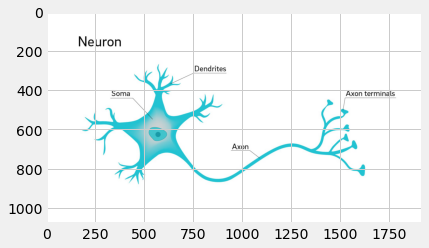

In [3]:
#Defining subcellular location where each RNA population was harvested from 
#Enter Directory below
neuron = plt.imread("Neuron.jpg")
plt.imshow(neuron)

print('In neurons the cell body is called the soma and the dendrites and axons are collectively called neurites')

In [4]:
#Importing dataset produced by biomart from RNAs enriched in the neurites of cortical neurons
NeuriteTable = pd.read_csv("V_neurite.csv")
NeuriteTable.head()

,Gene name,Gene % GC content,Strand,Transcript count,Transmembrane helices,Chromosome/scaffold name
0,Vwf,48.10,1,10,NaN,6
1,Adamtsl5,55.61,-1,7,NaN,10
2,C77080,52.43,-1,4,NaN,4
3,Adcy5,50.48,1,1,TMhelix,16
4,Fermt2,43.51,-1,4,NaN,14


In [5]:
#Importing dataset produced by biomart from RNAs enriched in the soma of cortical neurons
SomaTable = pd.read_csv("v_soma.csv")
SomaTable.head()

,Gene name,Gene % GC content,Strand,Transcript count,Transmembrane helices,Chromosome/scaffold name
0,Polb,42.72,-1,1,NaN,8
1,Siah1b,40.43,-1,1,NaN,X
2,Mrpl39,43.45,-1,2,NaN,16
3,Zfp788,40.86,1,7,NaN,7
4,Cxxc1,57.88,1,1,NaN,18


In [6]:
###Cleaning up the data 
#Changing the Headers to be easier to work with 
NeuriteTable = NeuriteTable.rename(columns={'Gene % GC content': 'PercentGC', 
                                            'Chromosome/scaffold name': 'Chr', 
                                            'Transmembrane helices': 'TMHelix'})

SomaTable = SomaTable.rename(columns={'Gene % GC content': 'PercentGC', 
                                            'Chromosome/scaffold name': 'Chr', 
                                            'Transmembrane helices': 'TMHelix'})

#Changing the NaN values in TMHelix to False:0 if it does not contain a TM Helix, True:1 if it does
NeuriteTable.TMHelix = NeuriteTable.TMHelix.map({'TMhelix': 1, np.nan: 0})
SomaTable.TMHelix = SomaTable.TMHelix.map({'TMhelix': 1, np.nan: 0})

#Checking one of the files to see the changes
NeuriteTable.head()
#SomaTable.head()

,Gene name,PercentGC,Strand,Transcript count,TMHelix,Chr
0,Vwf,48.10,1,10,0,6
1,Adamtsl5,55.61,-1,7,0,10
2,C77080,52.43,-1,4,0,4
3,Adcy5,50.48,1,1,1,16
4,Fermt2,43.51,-1,4,0,14


In [7]:
#Checking that all of the NaN values were changed and no other columns contain null data
print("Null Values in Somatic File\n", SomaTable.isnull().sum())
print("Null Values in Neurite File\n", NeuriteTable.isnull().sum())


Null Values in Somatic File
 Gene name           0
PercentGC           0
Strand              0
Transcript count    0
TMHelix             0
Chr                 0
dtype: int64
Null Values in Neurite File
 Gene name           0
PercentGC           0
Strand              0
Transcript count    0
TMHelix             0
Chr                 0
dtype: int64


In [8]:
#Checking the types of each column 
print(NeuriteTable.dtypes)
print("Note that Chromosome loaded correctly as a classifier, not a scalar value int64")

Gene name            object
PercentGC           float64
Strand                int64
Transcript count      int64
TMHelix               int64
Chr                  object
dtype: object
Note that Chromosome loaded correctly as a classifier, not a scalar value int64


In [9]:
#Summaries of the data
print("Neurite Summary", "\n", NeuriteTable.describe(), "\n\n", 
      "Soma Summary", "\n", SomaTable.describe())

Neurite Summary 
         PercentGC      Strand  Transcript count     TMHelix
count  482.000000  482.000000        482.000000  482.000000
mean    49.597842    0.000000          5.746888    0.176349
std      5.328318    1.001039          4.647473    0.381512
min     37.130000   -1.000000          1.000000    0.000000
25%     45.530000   -1.000000          2.000000    0.000000
50%     50.405000    0.000000          5.000000    0.000000
75%     53.570000    1.000000          8.000000    0.000000
max     65.490000    1.000000         26.000000    1.000000 

 Soma Summary 
          PercentGC       Strand  Transcript count      TMHelix
count  2042.000000  2042.000000       2042.000000  2042.000000
mean     46.631249     0.010774          4.599412     0.044074
std       5.282576     1.000187          3.712627     0.205311
min      34.430000    -1.000000          1.000000     0.000000
25%      42.670000    -1.000000          2.000000     0.000000
50%      46.045000     1.000000          4.000

In [10]:
#Merging the data to one dataframe

#Giving each file a classier column Neurite: 1, Soma: 0
NeuriteTable['Class'] = 1
SomaTable['Class'] = 0

#merging
df= NeuriteTable.append(SomaTable)
df.head()

,Gene name,PercentGC,Strand,Transcript count,TMHelix,Chr,Class
0,Vwf,48.10,1,10,0,6,1
1,Adamtsl5,55.61,-1,7,0,10,1
2,C77080,52.43,-1,4,0,4,1
3,Adcy5,50.48,1,1,1,16,1
4,Fermt2,43.51,-1,4,0,14,1



***

### Comparing Features between Soma and Neurite populations

    Chromosome Level: Chr
    Gene Level: Transcript count
    RNA Level: PercentGC
    Protein Level: TMHelix

Given that chromosomes are named in descending size
 the appearance higher counts for chromosomes 1-11 is not unexpected
 An ANOVA could tell me if any are overrepresented, but it would be too underpowered to trust


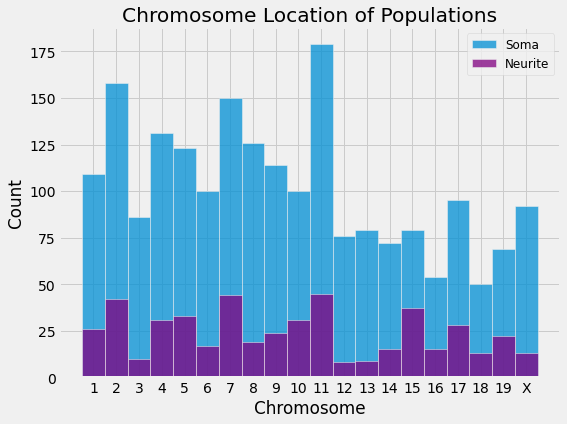

In [11]:
###CHROMOSOME LEVEL: Chromosome Location
#Which chromosomes encode the genes for these RNAs?

#Sorting the chromosomes to be in numerical order as objects
NChrList = list(NeuriteTable['Chr'])
NChrList.sort(key= lambda x: int(x) if x != 'X' else 23)
SChrList = list(SomaTable['Chr'])
SChrList.sort(key= lambda x: int(x) if x != 'X' else 23)

#plotting
plt.figure(figsize=(8,6))
sns.histplot(SChrList, label="Soma")
sns.histplot(NChrList, label="Neurite", color= "purple")
plt.title('Chromosome Location of Populations')
plt.xlabel('Chromosome')
plt.ylabel('Count')
plt.legend(prop={'size': 12})

#stats and summary
print("Given that chromosomes are named in descending size\n",
      "the appearance higher counts for chromosomes 1-11 is not unexpected\n",
      "An ANOVA could tell me if any are overrepresented, but it would be too underpowered to trust")

Ttest_indResult(statistic=5.797909985038282, pvalue=7.552378415167103e-09)
The average number of transcripts of encoding genes is significantly greater for the neurite population


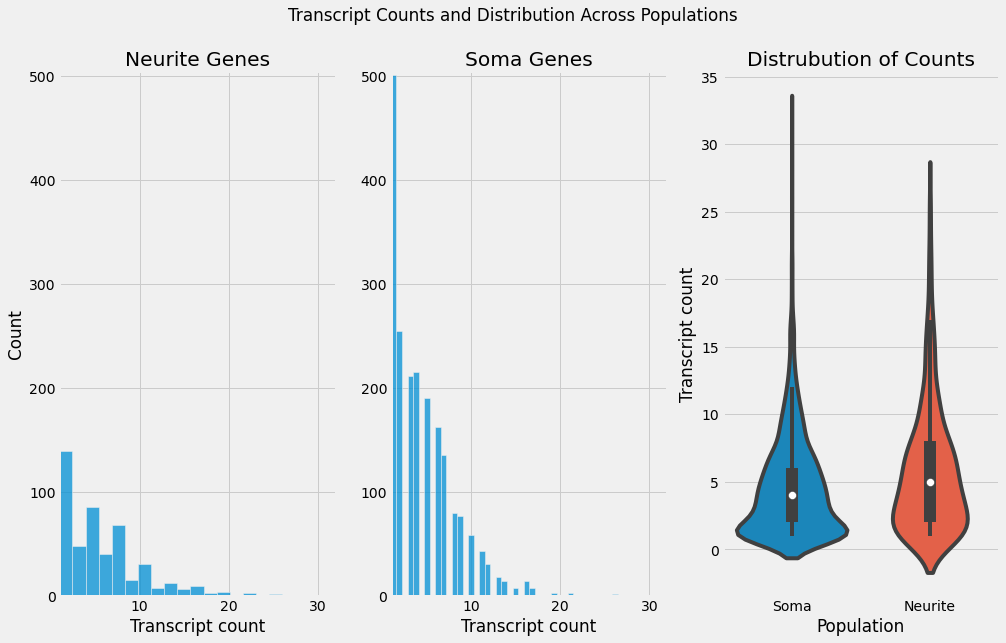

In [12]:
###GENE LEVEL: Transcript count
#Trancript Number for the genes that encode the RNAs located in neurites 
#An increased transcript number could mean location regulation through motif exclusion/inclusion 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 9))

sns.histplot(NeuriteTable['Transcript count'], ax=ax1)
ax1.set_ylim([0, (len(df['Transcript count'])/5)])
ax1.set_xlim([1, df['Transcript count'].max()])
ax1.set_ylabel('Count')
ax1.set_title('Neurite Genes')

sns.histplot(SomaTable['Transcript count'], ax=ax2)
ax2.set_ylim([0, (len(df['Transcript count'])/5)])
ax2.set_xlim([1, df['Transcript count'].max()])
ax2.set_ylabel('')
ax2.set_title('Soma Genes')

sns.violinplot(x='Class', y="Transcript count", data=df, ax=ax3)
ax3.set_title('Distrubution of Counts')
ax3.set_xticklabels(['Soma', 'Neurite'])
ax3.set_xlabel('Population')

f.suptitle('Transcript Counts and Distribution Across Populations')

#stats
#This isn't normally distributed, but it will be generally work without further stats packages 
print(stats.ttest_ind(NeuriteTable['Transcript count'],
                SomaTable['Transcript count']))
#summary
print("The average number of transcripts of encoding genes is significantly greater for the neurite population")
             

Ttest_indResult(statistic=11.07133099701241, pvalue=7.48920696119014e-28)
Neurite RNAs have a significatly higher average GC content


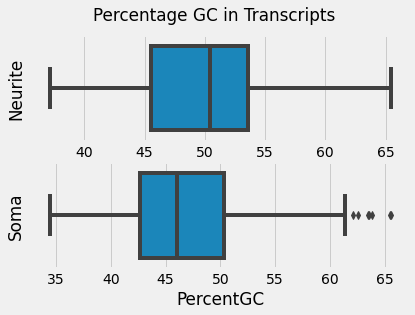

In [13]:
###RNA SEQUENCE LEVE: GC Content
#Percent of the transcript that is GC 
#Higher GC content can create stable structures and binding 
f, (ax1, ax2) = plt.subplots(2, 1)

sns.boxplot(NeuriteTable['PercentGC'], ax=ax1)
ax1.set_ylabel('Neurite')
sns.boxplot(SomaTable['PercentGC'], ax=ax2)
ax2.set_ylabel('Soma')

f.suptitle('Percentage GC in Transcripts')

#stats
print(stats.ttest_ind(NeuriteTable['PercentGC'],
                SomaTable['PercentGC']))
#summary
print("Neurite RNAs have a significatly higher average GC content")




In [14]:
###PROTEIN LEVEL: Transmembrane Helix 
#A TMHelix is common in proteins involved with neurite functions

#Percentage of Neurite RNAs encoding a protein that includes a Transmembrane Helix
print('Neutite: ' + str(sum(NeuriteTable['TMHelix'])/len(NeuriteTable['TMHelix'])))

#Percentage of Soma RNAs encoding a Transmembrane Helix
print('Soma: ' + str(sum(SomaTable['TMHelix'])/len(SomaTable['TMHelix'])))

#stats
oddsratio, pvalue = stats.fisher_exact([[sum(NeuriteTable['TMHelix']), len(NeuriteTable['TMHelix']) - sum(NeuriteTable['TMHelix'])], [sum(NeuriteTable['TMHelix']), len(SomaTable['TMHelix']) - sum(SomaTable['TMHelix'])]])
print("pvalue:", pvalue)


#summary
print("Neurite RNAs are more likely to encode for a transmembrane helix")



Neutite: 0.17634854771784234
Soma: 0.04407443682664055
pvalue: 3.2471475719141496e-21
Neurite RNAs are more likely to encode for a transmembrane helix



***

### Classification Tree

Individual features of the RNA populations differ, but can we use all of the features to attempt to classify them?



In [15]:
#Splitting the data to testing and training data

testsize=0.25

X_train, X_test, Y_train, Y_test = train_test_split(df[['Strand', 'PercentGC', 'Transcript count', 'TMHelix']], 
                                                    df['Class'], random_state=0, test_size=testsize)
X_train.head()

,Strand,PercentGC,Transcript count,TMHelix
1196,1,49.90,1,0
1543,-1,40.13,2,0
266,-1,44.60,1,0
795,1,47.92,3,0
458,-1,59.51,3,0


In [16]:
#testing to see which depth gives us the best classification tree

max_depth_range = range(1,25)
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0, criterion= "entropy")
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    accuracy.append(score)

print(accuracy)
print("\nMax accuracy:", max(accuracy), )
print("Ideal depth:", (accuracy.index(max(accuracy))+1))


[0.8193343898573693, 0.8367670364500792, 0.8335974643423137, 0.8399366085578447, 0.8304278922345484, 0.8304278922345484, 0.8335974643423137, 0.8320126782884311, 0.8351822503961965, 0.8304278922345484, 0.8304278922345484, 0.8256735340729001, 0.820919175911252, 0.8129952456418383, 0.8098256735340729, 0.803486529318542, 0.8019017432646592, 0.7955625990491284, 0.7828843106180665, 0.7797147385103012, 0.7749603803486529, 0.7733755942947702, 0.768621236133122, 0.7702060221870047]

Max accuracy: 0.8399366085578447
Ideal depth: 4


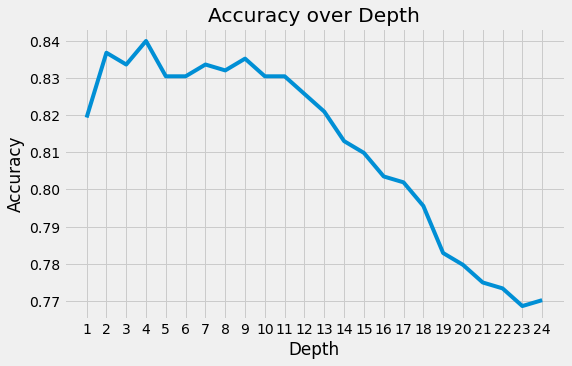

In [17]:
#Plotting accuracy over depth to visualize the best depth to use
fig, ax = plt.subplots(figsize=[8,5])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Depth')
ax.set_title('Accuracy over Depth')
ax.set_xticks(max_depth_range)
ax.grid(True)
plt.plot(max_depth_range, accuracy)
plt.show()

In [18]:
#Training the classification modeler using the depth determined above
clf = DecisionTreeClassifier(max_depth = (accuracy.index(max(accuracy))+1) , random_state = 0, criterion= "entropy")
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print(score)

0.8399366085578447


In [19]:
#Running the test set against the classifier
predictions = clf.predict(X_test)

#Looking at the predictions
clf.predict(X_test[1:10])

array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

[Text(217.9872, 209.952, 'X[1] <= 49.625\nentropy = 0.711\nsamples = 1893\nvalue = [1525, 368]'),
 Text(120.2688, 163.296, 'X[2] <= 5.5\nentropy = 0.564\nsamples = 1255\nvalue = [1089, 166]'),
 Text(60.1344, 116.64, 'X[3] <= 0.5\nentropy = 0.49\nsamples = 842\nvalue = [752, 90]'),
 Text(30.0672, 69.98400000000001, 'X[1] <= 39.99\nentropy = 0.451\nsamples = 783\nvalue = [709, 74]'),
 Text(15.0336, 23.328000000000003, 'entropy = 0.211\nsamples = 90\nvalue = [87, 3]'),
 Text(45.1008, 23.328000000000003, 'entropy = 0.477\nsamples = 693\nvalue = [622, 71]'),
 Text(90.2016, 69.98400000000001, 'X[2] <= 2.5\nentropy = 0.843\nsamples = 59\nvalue = [43, 16]'),
 Text(75.168, 23.328000000000003, 'entropy = 0.987\nsamples = 30\nvalue = [17, 13]'),
 Text(105.23519999999999, 23.328000000000003, 'entropy = 0.48\nsamples = 29\nvalue = [26, 3]'),
 Text(180.4032, 116.64, 'X[2] <= 19.5\nentropy = 0.689\nsamples = 413\nvalue = [337, 76]'),
 Text(150.336, 69.98400000000001, 'X[1] <= 49.265\nentropy = 0.671\

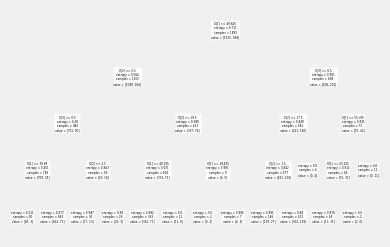

In [20]:
#Plotting the tree
tree.plot_tree(clf) 

There are a lot of inaccurate classifications, this may be overfitted


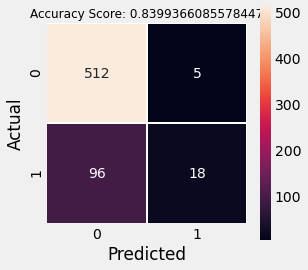

In [21]:
#Confusion Matrix
cm = metrics.confusion_matrix(Y_test, predictions)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square= True);
plt.ylabel("Actual");
plt.xlabel("Predicted");
plt.title('Accuracy Score: {}'.format(score), size = 12);

print("There are a lot of inaccurate classifications, this may be overfitted")

In [22]:
#null hypothesis test
MajorClass = max(Y_test.value_counts())
null = MajorClass / len(X_test)
print(null)
           
if null < (max(accuracy)):
    print("We reject the null!")
else:
    print("This could likely just be random")

0.8193343898573693
We reject the null!


In [23]:
importances_tree = pd.DataFrame({'feature':X_train.columns, 'importance':np.round(clf.feature_importances_,3)})
importances_tree = importances_tree.sort_values('importance', ascending=False).set_index('feature')

print(importances_tree)

print("\nGiven that there are so few have a TM Helix(a structure with high GC content) and strand was not significant by itself, \nit makes sense that the splits would rely more heavily on Percent GC and Transcript count to do prediction. \nSince features are correlated, perhaps a random forest would do a better job at predicting classifications")

                  importance
feature                     
PercentGC              0.512
TMHelix                0.276
Transcript count       0.213
Strand                 0.000

Given that there are so few have a TM Helix(a structure with high GC content) and strand was not significant by itself, 
it makes sense that the splits would rely more heavily on Percent GC and Transcript count to do prediction. 
Since features are correlated, perhaps a random forest would do a better job at predicting classifications



***

### Random Forest




In [24]:
#Declaring which columns to use for classifiers
feature_cols = ['Strand', 'PercentGC', 'Transcript count', 'TMHelix']
X = df[feature_cols]
y = df.Class

In [25]:
#splitting data
#adding rf for random forest to not reuse variables from the classification tree
#Using the same random state to better compare between trees
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(X,y, random_state = 0)

In [26]:
#determing the best depth 
max_depth_range = range(1,25)
accuracy = []

for depth in max_depth_range:
    
    clf_rf = RandomForestClassifier(n_estimators=150, max_depth= depth, random_state= 0)
    clf_rf.fit(Xrf_train, yrf_train)
    score = clf_rf.score(Xrf_test, yrf_test)
    accuracy.append(score)

print(accuracy)
print("\nMax accuracy:", max(accuracy), )
print("Ideal depth:", (accuracy.index(max(accuracy))+1))

[0.8193343898573693, 0.8351822503961965, 0.8367670364500792, 0.8367670364500792, 0.8320126782884311, 0.8320126782884311, 0.8304278922345484, 0.8304278922345484, 0.8272583201267829, 0.8177496038034865, 0.8161648177496038, 0.8114104595879557, 0.8019017432646592, 0.7987321711568938, 0.7892234548335975, 0.7828843106180665, 0.7797147385103012, 0.7797147385103012, 0.7733755942947702, 0.768621236133122, 0.7717908082408875, 0.768621236133122, 0.7702060221870047, 0.7717908082408875]

Max accuracy: 0.8367670364500792
Ideal depth: 3


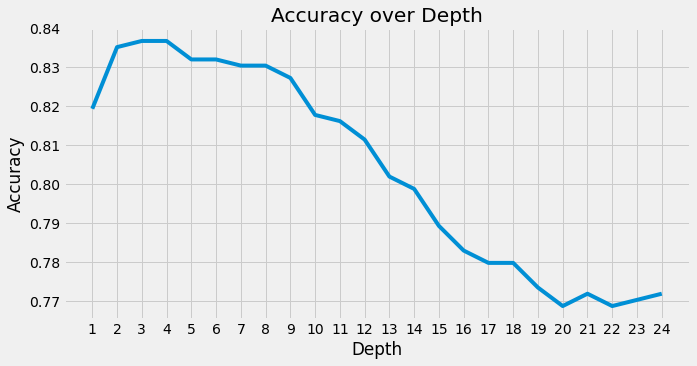

In [27]:
#Visualizing accuracy over depth 
fig, ax = plt.subplots(figsize=[10,5])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Depth')
ax.set_title('Accuracy over Depth')
ax.set_xticks(max_depth_range)
ax.grid(True)
plt.plot(max_depth_range, accuracy)
plt.show()

In [28]:
#Train the random forest 
clf_rf = RandomForestClassifier(n_estimators=150, max_depth= (accuracy.index(max(accuracy))+1) , random_state= 0)
clf_rf.fit(Xrf_train, yrf_train)
predictions_forest = clf_rf.predict(Xrf_test)
score = clf_rf.score(Xrf_test, yrf_test)
print(score)

0.8367670364500792


In [29]:
# Compute feature importances.
importances_forest = pd.DataFrame({'feature':feature_cols, 'importance':clf_rf.feature_importances_}).sort_values(by='importance')
importances_forest = importances_forest.sort_values('importance', ascending=False).set_index('feature')

print("Importances from a simple decision tree:\n", importances_tree, "\n\n")
print("Importances from a random forest model:\n", importances_forest)


Importances from a simple decision tree:
                   importance
feature                     
PercentGC              0.512
TMHelix                0.276
Transcript count       0.213
Strand                 0.000 


Importances from a random forest model:
                   importance
feature                     
PercentGC           0.522348
TMHelix             0.287865
Transcript count    0.177318
Strand              0.012469


There are EVEN MORE inaccurate classifications- we must be overfitting


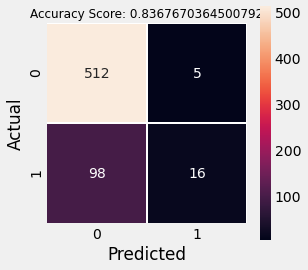

In [30]:
#Confusion Matrix

cmrf = metrics.confusion_matrix(yrf_test, predictions_forest)
plt.figure(figsize=(4,4))
sns.heatmap(cmrf, annot=True, fmt=".0f", linewidths=.5, square= True);
plt.ylabel("Actual");
plt.xlabel("Predicted");
plt.title('Accuracy Score: {}'.format(score), size = 12);

print("There are EVEN MORE inaccurate classifications- we must be overfitting")

### Summary

**Differences between RNA populations**

The two RNA populations, Soma and Neurite, differ on average on individual features:

1. Transcript count pvalue=7.55e-09
2. PercentGC pvalue=7.48e-28
3. TMHelix pvalue=3.24e-21

A classification tree is able to predict RNA population better than by chance on the features of
Strand, PercentGC, Transcript count, and TMHelix.

A random forest classification is also able to predict classification of RNA population better than chance on the 
features of Strand, PercentGC, Transcript count, and TMHelix.

**Importance:**

Translational regulation is important for creating the correct proteins at the right time and places within the cell.  
One of these mechanisms that controls this is RNA localization within the cell, but it is unclear what features 
determine where RNA will be transported. 

This notebook suggests that many features differ between the population, 
but none of the features, nor their combinations, are deterministic in classifying 
which population the RNA belongs. 

**Further Testing:**

Further testing of the best split percentage of the data could help reduce the overfitting observed. 
One challenging part of this dataset is the unbalanced data. There are far more datapoints for the Soma RNA 
population. Finding a way to reduce the influence of this imbalance on the training would improve predictions.
Additionally, increasing the number of features could improve predictions as well. More data, including 
length of the transcripts, motifs, and transcript type, could be valuable data in the models. 
